In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

First you need to build the graph in networkX.  Barabasi-Albert graphs are supposed to be similar to human networks.

In [320]:
pop_size = 50000
# pop = nx.barabasi_albert_graph(pop_size, 10, seed = 5)
pop = nx.powerlaw_cluster_graph(pop_size, m=7, p = .2, seed=5)

We need to choose an initial infected person.  You can start with more infected people, but need to make edits below.

In [321]:
first = np.random.randint(pop_size-pop_size//5)+pop_size//5

This is where you set up initial parameters for the transmition.

In [343]:
N_max = 20  #The hard cap of the number of people a person can interact with in a day 
             #this can be edited during run to simulate social distancing
p=.2        #The percentage of persons contacts they interact with
             #this can be edited during run to simulate social distancing
symp_days = 10    # number of time steps until symptoms appear
start_cont_days = 6  # number of time steps until contagious starts
cont_days = 16    # number of time steps from contraction to not contagious
cure_days = 24   # number of time steps from contraction to being cured
mortality_rate = 0.03   #mortality rate
death_prob = np.exp(np.log(1-mortality_rate)/(cure_days-cont_days))  # This is used to simulate death
p_trans = .125/2   # probability an interaction results in an infection
N = 150       # number of iterations to run simulation for
p_asymp = .2
p_mild = .6
p_severe = .15
p_critical = .05

if p_asymp+p_mild+p_severe+p_critical ==1:
    pass
else:
    print('severity probabilities do not sum to 1')

cont = np.zeros((N,))     # where number of contagious each time step people are stored
infect = np.zeros((N,))  # where number of infected each time step people are stored
cured = np.zeros((N,))   # where number of cured each time step people are stored
dead = np.zeros((N,))  # where number of dead each time step people are stored
R0 = np.zeros((N,))  # where average number of infections per contagious person is stored

######
#  Using p_var you can simulate the effects of temperature
#  This messy function simulates resurgence 
# p_var = ((np.tanh(-1*np.sin(3.14*(np.arange(N)-N/4)/(N/3)))+1)/2*1/2+1/2)*p_trans*.95+1.1*(np.tanh(-1*np.sin(3.14*(np.arange(N)+N/2)/N))+1)*p_trans/4

p_var = np.ones(N)*p_trans

In [344]:
####
# Setting attributes

nx.set_node_attributes(pop, 0,'condition')           # tracker for how many time steps since infection
nx.set_node_attributes(pop, 0,'contagious')         # 1 contagious 0 not contagious
nx.set_node_attributes(pop, 0,'dead')
nx.set_node_attributes(pop, 0,'N_infect')           # tracker for how many people this person has infected 
nx.set_node_attributes(pop, 0,'severity')           # 0 = asymptomatic, 1 = mild, 2 = severe, 3 = critical

######
# Setting initial patients.  You can repeat this for multiple nodes if you want multiple seed patients

pop.node[first]['condition'] = start_cont_days      # first person starts out contagious
pop.node[first]['contagious'] = 1
pop.node[first]['severity'] = 1                     # first person has mild symptoms


np.random.seed(seed=10)       # for reproducibility



for i in range(N):
    l = [x for x,y in pop.nodes(data=True) if y['contagious']==1]   # list of everyont contagious
    L = [x for x,y in pop.nodes(data=True) if ((y['condition']>symp_days)&(y['condition']<cure_days-1))] # list of people with symptoms
    L2 = [x for x,y in pop.nodes(data=True) if ((y['condition']>0)&(y['condition']<start_cont_days))] # list of people infected but not contagious
    infect[i] = len([x for x,y in pop.nodes(data=True) if y['condition']>0])
    cont[i] = len(l)
    cured[i] = len([x for x,y in pop.nodes(data=True) if y['condition']>cure_days-2])
    dead[i] = len([x for x,y in pop.nodes(data=True) if y['dead']==1])
    #######
    # here you can institute social policies 
    if infect[i]>pop_size//100:
        N_max = N_max
    else:
        pass
    
    p_trans = p_var[i]

    ######
    # This is where interactions cause new patients
    for a in l:
        temp = np.minimum(np.random.randint(low=0,high = int(len(list(pop.neighbors(a)))*2*p)+1),N_max)
        l2 = np.random.choice(list(pop.neighbors(a)),temp, replace=False)
        for j in l2:
            if pop.node[j]['condition'] == 0:
                if np.random.uniform()<p_trans:       # interaction caused infection
                    pop.node[j]['condition'] = 1
                    pop.node[j]['contagious'] = 1
                    r_temp = np.random.uniform()
                    if r_temp<p_asymp:
                        pop.node[j]['severity'] = 0
                    elif r_temp<(p_mild):
                        pop.node[j]['severity'] = 1
                    elif r_temp<(p_mild+p_severe):
                        pop.node[j]['severity'] = 2
                    else:
                        pop.node[j]['severity'] = 3
                    pop.node[a]['N_infect'] +=1       # for keeping track of how many infections someone caused
                else:                                 # interaction did not caused infection
                    pass
            else:
                pass
            
    for a in l:
        R0[i] += pop.node[a]['N_infect']/len(l)
    ######
    # This is where people become contagious
    for a in L2:
        if pop.node[a]['condition']<start_cont_days:
            pop.node[a]['condition'] += 1
        elif pop.node[a]['condition']==start_cont_days:
            pop.node[a]['condition'] += 1
            pop.node[a]['contagious'] = 1
        else:
            print('error')
                
        
    ######
    # This is where people stop being contagious
    for a in l:
        if pop.node[a]['condition'] < cont_days:
            pop.node[a]['condition'] += 1
        else:
            pop.node[a]['contagious'] = 0
            pop.node[a]['condition'] += 1
    ######
    # This is where people die 
    for a in L:
        temp = np.random.uniform()
        if temp>death_prob:
            pop.node[a]['contagious'] = 0
            pop.node[a]['dead'] = 1
        else:
            pop.node[a]['condition'] += 1


[Text(0.5, 0, 'time steps')]

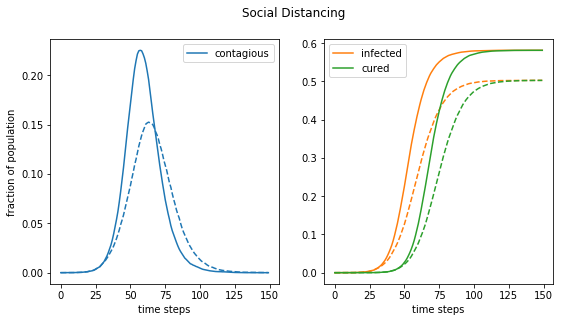

In [372]:
fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2, figsize=(9, 4.5))
fig.suptitle('Social Distancing')
ax1.plot(cont/pop_size, 'C0', label = 'contagious')
ax1.plot(cont1/pop_size, 'C0--')
ax1.legend()
ax1.set(xlabel='time steps', ylabel='fraction of population')

ax2.plot(infect/pop_size,'C1',label = 'infected')
ax2.plot(infect1/pop_size, 'C1--')
ax2.plot(cured/pop_size,'C2',label = 'cured')
ax2.plot(cured1/pop_size, 'C2--')
ax2.legend()
ax2.set(xlabel='time steps')

In [342]:
cont1 = cont
infect1 = infect
cured1 = cured